In [1]:
import numpy as np
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#import pymp
from scipy.optimize import minimize

In [2]:
L=32.0
N=int(L)*32
dx=L/N
R=0.5

In [3]:
def wrap(x):
    if(np.abs(x)>L/2):
        x=np.abs(x)-L
    return x

def ini_Vext(a,b,c):
    V=np.zeros(N)
    for i in range(int(N/2)):
        if(i*dx<L/2-b):
            V[i]=a*np.abs(i*dx+b-L/2)**c
        else:
            V[i]=0
    for i in range(int(N/2),N):        
        if(i*dx>L/2+b):
            V[i]=a*np.abs(i*dx-b-L/2)**c
        else:
            V[i]=0
    for i in range(N):
        if(V[i]>10):
            V[i]=10
    return V         

def ini_Vext_guass(seed=0):
    np.random.seed(seed)
    V = np.zeros(N)
    x = np.linspace(0,L-dx,N)
    for i in range (4):
        a = np.random.rand()*6-3
        b = np.random.rand()*L
        c = np.random.rand()+1
        for j in range (N):
            V[j] += -a*np.exp(-(wrap(j*dx-b))**2/(2*c**2))
    for j in range (N):
        if(np.abs(V[j])>3):
            V[j]=3.0*V[j]/V[j]
    return V-np.mean(V)    

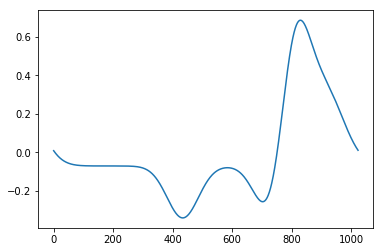

In [4]:
plt.plot(ini_Vext_guass())

In [5]:
def mu_r (rho):
     return (2*R*rho)/(1 - 2*R*rho) - np.log(1 - 2*R*rho)+np.log(rho)

In [6]:
def find_rho(x,arg):
    return (mu_r(x)-arg)**2


In [7]:
x0=0.5
mu=np.log(3.5)
res = minimize(find_rho, args=mu, x0=x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 46


In [8]:
res.x[0]

0.5305801928043364

In [9]:
x0=0.5
mu=np.log(.5)
res = minimize(find_rho, args=mu, x0=x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 28
         Function evaluations: 56


In [10]:
res.x[0]

0.26020932197570784

In [11]:
def initial_w():
    k=np.linspace(0,int(N/2),int(N/2)+1)*2*np.pi/L
    w0=2*np.cos(k*R)/2
    k[0]=1
    w1=2*np.sin(k*R)/k
    w1[0]=2*R
    return w0,w1

In [12]:
def cal_n0(rho):
    return np.fft.irfft(np.fft.rfft(rho)*w0)
def cal_n1(rho):
    return np.fft.irfft(np.fft.rfft(rho)*w1)

In [13]:
def cal_c1(rho):
    n0=cal_n0(rho)
    n1=cal_n1(rho)
    F0=-np.log(1-n1)
    F1=n0/(1-n1)
    
    return cal_n0(F0)+cal_n1(F1)
    

In [14]:
def update_rho(rho,c1,Vext,mu,alpha=0.01):
    rho_new =np.exp(-c1-Vext)
    #mu = np.log(np.sum(rho)/np.sum(rho_new))
    rho_new*=np.exp(mu)
    rho = (1-alpha)*rho+alpha*rho_new
    err = np.sum((rho_new-rho)**2)
    return rho,err

In [15]:
w0,w1=initial_w()

In [16]:
data_file = "HR_data/"

In [55]:
def minimization(seed):
    np.random.seed(seed)
    rho0=np.random.uniform(0.1,0.6)
    Vext=ini_Vext_guass(seed)
    Vext[0:int(1.0/dx)+1]=10**8
    rho=np.full(N,rho0)
    z=np.random.uniform(0.5,3.5)
    for i in range(10000):
        c1=cal_c1(rho)
        rho,err=update_rho(rho,c1,Vext,np.log(z),alpha=0.01)
        if(err<10**-10):
            print("i="+str(i))
            break
    return rho0,rho,Vext,z   

def minimization_test(seed):
    np.random.seed(seed)
    rho0=np.random.uniform(0.1,0.6)
    Vext=np.zeros(N)
    Vext[0:int(1/dx+1)]=10**8
    Vext+=ini_Vext_guass(seed+10**8)
    
    rho=np.full(N,rho0)
    z=np.random.uniform(0.5,3.5)
    for i in range(10000):
        c1=cal_c1(rho)
        rho,err=update_rho(rho,c1,Vext,np.log(z),alpha=0.01)
        if(err<10**-10):
            print("i="+str(i))
            break
    return rho0,rho,Vext,z   

def minimization_wall(seed):
    np.random.seed(seed)
    rho0=0.5+0.35/7*seed
    
    Vext=np.zeros(N)
    Vext[0:int(1/dx+1)]=10**8
    
    rho=np.full(N,rho0)
    z=np.exp(mu_r(rho0))
    for i in range(10000):
        c1=cal_c1(rho)
        rho,err=update_rho(rho,c1,Vext,np.log(z),alpha=0.01)
        if(err<10**-10):
            print("i="+str(i))
            break
    return rho0,rho,Vext,z   



def minimization_explor(seed):
    np.random.seed(seed)
    rho0=0.6+0.2*np.random.rand()
    
    Vext=np.zeros(N)
    Vext[0:int(1/dx+1)]=10**8
    Vext+=ini_Vext_guass(seed+10**6)
    rho=np.full(N,rho0)
    z=np.exp(mu_r(rho0))
    for i in range(100000):
        c1=cal_c1(rho)
        rho,err=update_rho(rho,c1,Vext,np.log(z),alpha=0.005)
        if(err<10**-10):
            print("i="+str(i)+" err ="+str(err))
            return rho0,rho,Vext,z,True
    return rho0,rho,Vext,z,False
        



In [18]:
batch_size = 1024
f = open(data_file +'parameter.dat', 'w')
f.write(str(L))
f.write("\n")
f.write(str(N))
f.write("\n")
f.write(str(batch_size))
f.close()

In [19]:
rho0_array = np.zeros((batch_size), dtype='float32')
f = open(data_file+'rho_z.dat', 'w')
for i in range (batch_size):
    seed = i
    rho0,rho,Vext,z=minimization(seed)
    rho0_array[i]=rho0
    np.savetxt(data_file+"rho_"+str(seed)+".dat",rho)
    np.savetxt(data_file+"Vext_"+str(seed)+".dat",Vext)
    #np.savetxt(r"./data/mu_"+str(seed)+".txt",np.array(mu))
    #np.savetxt(r"./data/inputs_"+str(seed)+".txt",np.append(np.append(rho,Vext),np.full(N,mu)))
    f.write(str(i)+"\t"+str(rho0_array[i])+"\t"+str(z)+"\n")
    print("batch data i = "+str(i))
    

#for i in range (batch_size):
#    f.write(str(i)+"\t"+str(rho0_array[i])+"\t"+str(mu_r(rho0_array[i]))+"\n")
f.close()

i=1543
batch data i = 0
i=1438
batch data i = 1
i=1390
batch data i = 2
i=1581
batch data i = 3
i=1790
batch data i = 4
i=1904
batch data i = 5
i=1478
batch data i = 6
i=1660
batch data i = 7
i=2049
batch data i = 8
i=1781
batch data i = 9
i=1523
batch data i = 10
i=1459
batch data i = 11
i=2110
batch data i = 12
i=1591
batch data i = 13
i=1688
batch data i = 14
i=1745
batch data i = 15
i=1643
batch data i = 16
i=1698
batch data i = 17
i=1788
batch data i = 18
i=1539
batch data i = 19
i=1949
batch data i = 20
i=1472
batch data i = 21
i=1961
batch data i = 22
i=1700
batch data i = 23
i=1539
batch data i = 24
i=1513
batch data i = 25
i=1568
batch data i = 26
i=1494
batch data i = 27
i=1506
batch data i = 28
i=1604
batch data i = 29
i=1390
batch data i = 30
i=1951
batch data i = 31
i=1538
batch data i = 32
i=1289
batch data i = 33
i=1691
batch data i = 34
i=1624
batch data i = 35
i=1570
batch data i = 36
i=1492
batch data i = 37
i=1578
batch data i = 38
i=1851
batch data i = 39
i=1769
bat

i=1519
batch data i = 320
i=1894
batch data i = 321
i=1312
batch data i = 322
i=1730
batch data i = 323
i=1702
batch data i = 324
i=1717
batch data i = 325
i=1604
batch data i = 326
i=1511
batch data i = 327
i=1662
batch data i = 328
i=1489
batch data i = 329
i=1823
batch data i = 330
i=1582
batch data i = 331
i=1340
batch data i = 332
i=1510
batch data i = 333
i=1741
batch data i = 334
i=1852
batch data i = 335
i=1517
batch data i = 336
i=1490
batch data i = 337
i=1734
batch data i = 338
i=1416
batch data i = 339
i=1261
batch data i = 340
i=1180
batch data i = 341
i=1710
batch data i = 342
i=2052
batch data i = 343
i=1258
batch data i = 344
i=1386
batch data i = 345
i=1476
batch data i = 346
i=1645
batch data i = 347
i=1635
batch data i = 348
i=1550
batch data i = 349
i=1426
batch data i = 350
i=1621
batch data i = 351
i=1385
batch data i = 352
i=1592
batch data i = 353
i=1947
batch data i = 354
i=1428
batch data i = 355
i=1502
batch data i = 356
i=1891
batch data i = 357
i=1776
batch

i=1529
batch data i = 636
i=1370
batch data i = 637
i=1570
batch data i = 638
i=2255
batch data i = 639
i=1438
batch data i = 640
i=1773
batch data i = 641
i=1561
batch data i = 642
i=2080
batch data i = 643
i=1705
batch data i = 644
i=1684
batch data i = 645
i=1338
batch data i = 646
i=1327
batch data i = 647
i=1636
batch data i = 648
i=1462
batch data i = 649
i=1741
batch data i = 650
i=1586
batch data i = 651
i=1613
batch data i = 652
i=1277
batch data i = 653
i=1472
batch data i = 654
i=1694
batch data i = 655
i=1507
batch data i = 656
i=1294
batch data i = 657
i=1577
batch data i = 658
i=1664
batch data i = 659
i=1591
batch data i = 660
i=1423
batch data i = 661
i=1923
batch data i = 662
i=1644
batch data i = 663
i=1746
batch data i = 664
i=1533
batch data i = 665
i=1533
batch data i = 666
i=1874
batch data i = 667
i=1692
batch data i = 668
i=1342
batch data i = 669
i=1248
batch data i = 670
i=1568
batch data i = 671
i=1344
batch data i = 672
i=1738
batch data i = 673
i=1622
batch

batch data i = 952
i=1983
batch data i = 953
i=1790
batch data i = 954
i=1509
batch data i = 955
i=1449
batch data i = 956
i=1926
batch data i = 957
i=1751
batch data i = 958
i=1618
batch data i = 959
i=1420
batch data i = 960
i=1346
batch data i = 961
i=1842
batch data i = 962
i=1680
batch data i = 963
i=1395
batch data i = 964
i=1895
batch data i = 965
i=2044
batch data i = 966
i=1500
batch data i = 967
i=1657
batch data i = 968
i=1747
batch data i = 969
i=2059
batch data i = 970
i=1388
batch data i = 971
i=2719
batch data i = 972
i=1624
batch data i = 973
i=1984
batch data i = 974
i=1417
batch data i = 975
i=1877
batch data i = 976
i=1757
batch data i = 977
i=2036
batch data i = 978
i=1743
batch data i = 979
i=1932
batch data i = 980
i=1757
batch data i = 981
i=1586
batch data i = 982
i=1846
batch data i = 983
i=1750
batch data i = 984
i=1569
batch data i = 985
i=1461
batch data i = 986
i=1965
batch data i = 987
i=1590
batch data i = 988
i=1544
batch data i = 989
i=1568
batch data i

0.27786508476769356

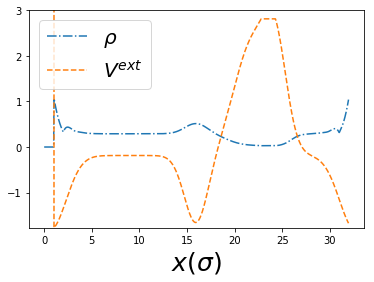

In [20]:
rho = np.loadtxt("./HR_data/rho_10.dat")
V = np.loadtxt("./HR_data/Vext_10.dat")
x = np.linspace(0,L-dx,N)
plt.plot(x,rho,"-.",label=r"$\rho$")
plt.plot(x,V,"--",label=r"$V^{ext}$")
#plt.plot(mu)
plt.ylim([min(V),3])
plt.xlabel(r"$x(\sigma)$",fontsize=25)
plt.legend(fontsize=20)
np.sum(rho*dx/L)

In [21]:
data_file='HR_data_test/'

batch_size =32
f = open(data_file +'parameter.dat', 'w')
f.write(str(L))
f.write("\n")
f.write(str(N))
f.write("\n")
f.write(str(batch_size))
f.close()

rho0_array = np.zeros((batch_size), dtype='float32')
f = open(data_file+'rho_z.dat', 'w')
for i in range (batch_size):
    seed = i
    rho0,rho,Vext,z=minimization_test(seed)
    rho0_array[i]=rho0
    np.savetxt(data_file+"rho_"+str(seed)+".dat",rho)
    np.savetxt(data_file+"Vext_"+str(seed)+".dat",Vext)
    #np.savetxt(r"./data/mu_"+str(seed)+".txt",np.array(mu))
    #np.savetxt(r"./data/inputs_"+str(seed)+".txt",np.append(np.append(rho,Vext),np.full(N,mu)))
    f.write(str(i)+"\t"+str(rho0_array[i])+"\t"+str(z)+"\n")
    print("batch data i = "+str(i))
    

#for i in range (batch_size):
#    f.write(str(i)+"\t"+str(rho0_array[i])+"\t"+str(mu_r(rho0_array[i]))+"\n")
f.close()

i=2083
batch data i = 0
i=1398
batch data i = 1
i=1813
batch data i = 2
i=1743
batch data i = 3
i=1684
batch data i = 4
i=1732
batch data i = 5
i=1757
batch data i = 6
i=1386
batch data i = 7
i=1620
batch data i = 8
i=1735
batch data i = 9
i=1501
batch data i = 10
i=1794
batch data i = 11
i=1911
batch data i = 12
i=2065
batch data i = 13
i=1365
batch data i = 14
i=1968
batch data i = 15
i=1604
batch data i = 16
i=1666
batch data i = 17
i=1286
batch data i = 18
i=1242
batch data i = 19
i=1614
batch data i = 20
i=1740
batch data i = 21
i=1519
batch data i = 22
i=1451
batch data i = 23
i=1705
batch data i = 24
i=1459
batch data i = 25
i=1490
batch data i = 26
i=1739
batch data i = 27
i=1717
batch data i = 28
i=1485
batch data i = 29
i=1334
batch data i = 30
i=1780
batch data i = 31


0.40407030851183756

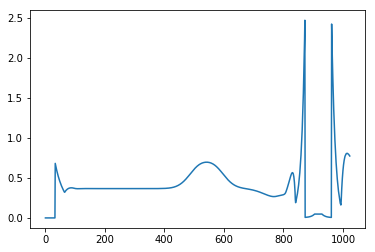

In [22]:
rho = np.loadtxt("./HR_data_test/rho_16.dat")
V = np.loadtxt("./HR_data_test/Vext_16.dat")

plt.plot(rho)
#plt.plot(V)
#plt.plot(mu)

np.sum(rho*dx/L)

In [23]:
data_file='HR_data_wall/'

batch_size =7
f = open(data_file +'parameter.dat', 'w')
f.write(str(L))
f.write("\n")
f.write(str(N))
f.write("\n")
f.write(str(batch_size))
f.close()

rho0_array = np.zeros((batch_size), dtype='float32')
f = open(data_file+'rho_z.dat', 'w')
for i in range (batch_size):
    seed = i
    rho0,rho,Vext,z=minimization_wall(seed)
    rho0_array[i]=rho0
    np.savetxt(data_file+"rho_"+str(seed)+".dat",rho)
    np.savetxt(data_file+"Vext_"+str(seed)+".dat",Vext)
    #np.savetxt(r"./data/mu_"+str(seed)+".txt",np.array(mu))
    #np.savetxt(r"./data/inputs_"+str(seed)+".txt",np.append(np.append(rho,Vext),np.full(N,mu)))
    f.write(str(i)+"\t"+str(rho0_array[i])+"\t"+str(z)+"\n")
    print("batch data i = "+str(i))
    

#for i in range (batch_size):
#    f.write(str(i)+"\t"+str(rho0_array[i])+"\t"+str(mu_r(rho0_array[i]))+"\n")
f.close()

i=1628
batch data i = 0
i=1761
batch data i = 1
i=1939
batch data i = 2
i=2185
batch data i = 3
i=2543
batch data i = 4
i=3106
batch data i = 5
i=4160
batch data i = 6


In [56]:
data_file='HR_data_exploration/'

batch_size = 256
f = open(data_file +'parameter.dat', 'w')
f.write(str(L))
f.write("\n")
f.write(str(N))
f.write("\n")
f.write(str(batch_size))
f.close()

count=0
rho0_array = np.zeros((batch_size), dtype='float32')
f = open(data_file+'rho_z.dat', 'w')
for i in range (batch_size*10):
    seed = i+1024
    rho0,rho,Vext,z,sucess=minimization_explor(seed)
    if(sucess):
        print(i,rho0)
        rho0_array[count]=rho0
        np.savetxt(data_file+"rho_"+str(count)+".dat",rho)
        np.savetxt(data_file+"Vext_"+str(count)+".dat",Vext)
        #np.savetxt(r"./data/mu_"+str(seed)+".txt",np.array(mu))
        #np.savetxt(r"./data/inputs_"+str(seed)+".txt",np.append(np.append(rho,Vext),np.full(N,mu)))
        f.write(str(count)+"\t"+str(rho0_array[count])+"\t"+str(z)+"\n")
        print("batch data i = "+str(i))
        print("batch data count = "+str(count))
        count+=1
        if(count==batch_size):
            break
#for i in range (batch_size):
#    f.write(str(i)+"\t"+str(rho0_array[i])+"\t"+str(mu_r(rho0_array[i]))+"\n")
f.close()

i=5952 err =9.983453912208486e-11
0 0.7295382461323956
batch data i = 0
batch data count = 0
i=5072 err =9.990592922006697e-11
1 0.7204497175762463
batch data i = 1
batch data count = 1
i=4427 err =9.999448961644943e-11
2 0.670329386466938
batch data i = 2
batch data count = 2
i=4579 err =9.986811354221498e-11
3 0.6219006506874883
batch data i = 3
batch data count = 3
i=6253 err =9.998635242624595e-11
4 0.7441444058423974
batch data i = 4
batch data count = 4
i=4089 err =9.947790420720831e-11
5 0.6082079710080257
batch data i = 5
batch data count = 5
i=5467 err =9.969121523869827e-11
6 0.6910127442512659
batch data i = 6
batch data count = 6
i=3872 err =9.953517726489867e-11
7 0.6002035942200145
batch data i = 7
batch data count = 7
i=5081 err =9.970692746339963e-11
8 0.6854563336758378
batch data i = 8
batch data count = 8
i=5413 err =9.983782017991139e-11
9 0.69738656427132
batch data i = 9
batch data count = 9
i=7237 err =9.968232901802962e-11
10 0.7611759177380706
batch data i = 10

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


i=4614 err =9.994411898120034e-11
45 0.6578480834985385
batch data i = 45
batch data count = 43
i=5610 err =9.968964448152658e-11
46 0.6416762544222102
batch data i = 46
batch data count = 44
i=4973 err =9.96817481026977e-11
47 0.6871006271783143
batch data i = 47
batch data count = 45
i=6354 err =9.986114477062521e-11
48 0.74759694225572
batch data i = 48
batch data count = 46
i=5565 err =9.961926286941092e-11
49 0.6623631172516046
batch data i = 49
batch data count = 47
i=5460 err =9.991763395600215e-11
50 0.7272217612778163
batch data i = 50
batch data count = 48
i=7346 err =9.983083794400821e-11
51 0.7404626864332164
batch data i = 51
batch data count = 49
i=7865 err =9.980870291164187e-11
52 0.7904516817878362
batch data i = 52
batch data count = 50
i=5711 err =9.978883062642699e-11
53 0.7130163271492318
batch data i = 53
batch data count = 51
i=5009 err =9.989693979843342e-11
54 0.6490631525843891
batch data i = 54
batch data count = 52
i=4829 err =9.959940067443634e-11
55 0.6700

i=4764 err =9.992358165128833e-11
133 0.6394842175932055
batch data i = 133
batch data count = 128
i=5379 err =9.972024780755521e-11
134 0.7150766510613914
batch data i = 134
batch data count = 129
i=3798 err =9.981064678306246e-11
135 0.6266752191281654
batch data i = 135
batch data count = 130
i=4306 err =9.994718788337307e-11
136 0.6024774242943995
batch data i = 136
batch data count = 131
i=5602 err =9.969128552170416e-11
137 0.6929971301928955
batch data i = 137
batch data count = 132
i=6047 err =9.968273236851208e-11
138 0.7413110995973743
batch data i = 138
batch data count = 133
i=5029 err =9.957742279927054e-11
139 0.6790763735560542
batch data i = 139
batch data count = 134
i=5737 err =9.984241116336109e-11
140 0.6081683142460886
batch data i = 140
batch data count = 135
i=4521 err =9.971137632579567e-11
141 0.6657906296690032
batch data i = 141
batch data count = 136
i=4565 err =9.963801299642233e-11
142 0.6924543555010826
batch data i = 142
batch data count = 137
i=4447 err

i=4670 err =9.989224238874986e-11
221 0.6667746424111052
batch data i = 221
batch data count = 211
i=4049 err =9.998941443241553e-11
222 0.6326485206577299
batch data i = 222
batch data count = 212
i=4884 err =9.972598681131849e-11
223 0.7101371545991811
batch data i = 223
batch data count = 213
i=5027 err =9.972869357899606e-11
224 0.6592579766598434
batch data i = 224
batch data count = 214
i=8297 err =9.999688882179898e-11
225 0.7962053368706141
batch data i = 225
batch data count = 215
i=3819 err =9.996200778600492e-11
226 0.6086500662979696
batch data i = 226
batch data count = 216
i=6252 err =9.969424259418919e-11
227 0.7172906695227316
batch data i = 227
batch data count = 217
i=4768 err =9.988470136908312e-11
228 0.6956291058634569
batch data i = 228
batch data count = 218
i=4274 err =9.974976617545571e-11
229 0.6318192605799821
batch data i = 229
batch data count = 219
i=5766 err =9.995808113109229e-11
230 0.7294183263851982
batch data i = 230
batch data count = 220
i=4815 err

In [57]:
print(max(rho0_array ),min(rho0_array ))

0.79941887 0.6001966
